In [1]:
import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
# from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm
from datetime import datetime
from babi_joint import BabiDataset, pad_collate
from torch.utils.data.dataset import Dataset
from glob import glob
from perceiver_pytorch.perceiver_io_gated_residual import PerceiverIO, PerceiverLM, PerceiverIObAbI, PerceiverIObAbInq
import time

In [2]:
# UT pondernet 1470003

model = PerceiverIObAbInq(
    num_tokens=179,
    context_max_seq_len=71*13,
#     question_max_seq_len=13,
    dim = 32,                    # dimension of sequence to be encoded
    queries_dim = 179,            # dimension of decoder queries
#     logits_dim = 50,            # dimension of final logits
    depth = 20,                   # depth of net
    num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 64,         # number of dimensions per cross attention head
    latent_dim_head = 64,        # number of dimensions per latent self attention head
    weight_tie_layers = True,   # whether to weight tie layers (optional, as indicated in the diagram)
    self_per_cross_attn = 1,     # number of self attention blocks per cross attention
    learn_latents=True
)

model_name = 'perceiverIO_bAbi_nq_deep_gru_res'
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

477228


In [3]:
batch_size=128
max_epochs = 150

babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
                           vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
vocab_size = len(babi_dataset.QA.VOCAB)
print('len(babi_dataset) train', len(babi_dataset))
print('vocab_size', vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = float('inf')

writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')
now = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")

for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    loss_sum = 0
    loss_count = 0
    model.train()
    babi_dataset.set_mode('train')
    train_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate
    )
    
    for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()

        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)
        
        logits = torch.squeeze(model(torch.cat((contexts, questions), 1)))
        loss = criterion(logits, answers)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        writer.add_scalars("losses_step", {"train_loss": loss.item() / contexts.size(0)}, epoch * len(train_loader) + batch_idx)
    
    train_loss = train_loss / len(train_loader.dataset)
    writer.add_scalars("losses_epoch", {"train_loss": train_loss}, epoch)
    train_loader_len = len(train_loader)
    
    model.eval()
    babi_dataset.set_mode('valid')
    val_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
    )
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
        
            contexts, questions, answers, tasks = data
            contexts = contexts.long().to(device)
            questions = questions.long().to(device)
            answers = answers.to(device)
        
            logits = torch.squeeze(model(torch.cat((contexts, questions), 1)))
            loss = criterion(logits, answers)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader.dataset)
    writer.add_scalars("losses_step", {"val_loss": val_loss}, (epoch + 1) * train_loader_len - 1)    
    writer.add_scalars("losses_epoch", {"val_loss": val_loss}, epoch)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint_{now}.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint_{now}.pt')
        val_loss_min = val_loss

len(babi_dataset) train 180000
vocab_size 179
cuda:0


Epoch 1/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.220480 	Validation Loss: 1.463989
Validation loss decreased (inf --> 1.463989).  Saving model ...


Epoch 2/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.365254 	Validation Loss: 1.307536
Validation loss decreased (1.463989 --> 1.307536).  Saving model ...


Epoch 3/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.218101 	Validation Loss: 1.165420
Validation loss decreased (1.307536 --> 1.165420).  Saving model ...


Epoch 4/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.112049 	Validation Loss: 1.103789
Validation loss decreased (1.165420 --> 1.103789).  Saving model ...


Epoch 5/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.063324 	Validation Loss: 1.067081
Validation loss decreased (1.103789 --> 1.067081).  Saving model ...


Epoch 6/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.031972 	Validation Loss: 1.031846
Validation loss decreased (1.067081 --> 1.031846).  Saving model ...


Epoch 7/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.010180 	Validation Loss: 1.018571
Validation loss decreased (1.031846 --> 1.018571).  Saving model ...


Epoch 8/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.992225 	Validation Loss: 0.991568
Validation loss decreased (1.018571 --> 0.991568).  Saving model ...


Epoch 9/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.971234 	Validation Loss: 0.965837
Validation loss decreased (0.991568 --> 0.965837).  Saving model ...


Epoch 10/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.951228 	Validation Loss: 0.946550
Validation loss decreased (0.965837 --> 0.946550).  Saving model ...


Epoch 11/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.930016 	Validation Loss: 0.931454
Validation loss decreased (0.946550 --> 0.931454).  Saving model ...


Epoch 12/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.911429 	Validation Loss: 0.913441
Validation loss decreased (0.931454 --> 0.913441).  Saving model ...


Epoch 13/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.892774 	Validation Loss: 0.900538
Validation loss decreased (0.913441 --> 0.900538).  Saving model ...


Epoch 14/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.872878 	Validation Loss: 0.878539
Validation loss decreased (0.900538 --> 0.878539).  Saving model ...


Epoch 15/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.854099 	Validation Loss: 0.857029
Validation loss decreased (0.878539 --> 0.857029).  Saving model ...


Epoch 16/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.834526 	Validation Loss: 0.843702
Validation loss decreased (0.857029 --> 0.843702).  Saving model ...


Epoch 17/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.825718 	Validation Loss: 0.842029
Validation loss decreased (0.843702 --> 0.842029).  Saving model ...


Epoch 18/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.814891 	Validation Loss: 0.832750
Validation loss decreased (0.842029 --> 0.832750).  Saving model ...


Epoch 19/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.806379 	Validation Loss: 0.826924
Validation loss decreased (0.832750 --> 0.826924).  Saving model ...


Epoch 20/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.796914 	Validation Loss: 0.823634
Validation loss decreased (0.826924 --> 0.823634).  Saving model ...


Epoch 21/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.790333 	Validation Loss: 0.810592
Validation loss decreased (0.823634 --> 0.810592).  Saving model ...


Epoch 22/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.784995 	Validation Loss: 0.811248


Epoch 23/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.779067 	Validation Loss: 0.806297
Validation loss decreased (0.810592 --> 0.806297).  Saving model ...


Epoch 24/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.774083 	Validation Loss: 0.798403
Validation loss decreased (0.806297 --> 0.798403).  Saving model ...


Epoch 25/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.769491 	Validation Loss: 0.798677


Epoch 26/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.765772 	Validation Loss: 0.798014
Validation loss decreased (0.798403 --> 0.798014).  Saving model ...


Epoch 27/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.761254 	Validation Loss: 0.798708


Epoch 28/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.760878 	Validation Loss: 0.797154
Validation loss decreased (0.798014 --> 0.797154).  Saving model ...


Epoch 29/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.753716 	Validation Loss: 0.793139
Validation loss decreased (0.797154 --> 0.793139).  Saving model ...


Epoch 30/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.749926 	Validation Loss: 0.785768
Validation loss decreased (0.793139 --> 0.785768).  Saving model ...


Epoch 31/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.751486 	Validation Loss: 0.789427


Epoch 32/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.744977 	Validation Loss: 0.783182
Validation loss decreased (0.785768 --> 0.783182).  Saving model ...


Epoch 33/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.739477 	Validation Loss: 0.784878


Epoch 34/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.734265 	Validation Loss: 0.782745
Validation loss decreased (0.783182 --> 0.782745).  Saving model ...


Epoch 35/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.730934 	Validation Loss: 0.781815
Validation loss decreased (0.782745 --> 0.781815).  Saving model ...


Epoch 36/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.725707 	Validation Loss: 0.778273
Validation loss decreased (0.781815 --> 0.778273).  Saving model ...


Epoch 37/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.722312 	Validation Loss: 0.785642


Epoch 38/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.717597 	Validation Loss: 0.780765


Epoch 39/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.713218 	Validation Loss: 0.779681


Epoch 40/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.709117 	Validation Loss: 0.784558


Epoch 41/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.703684 	Validation Loss: 0.777428
Validation loss decreased (0.778273 --> 0.777428).  Saving model ...


Epoch 42/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.698652 	Validation Loss: 0.787627


Epoch 43/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.694452 	Validation Loss: 0.783585


Epoch 44/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.690490 	Validation Loss: 0.781813


Epoch 45/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.685967 	Validation Loss: 0.777595


Epoch 46/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.679852 	Validation Loss: 0.779886


Epoch 47/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.675120 	Validation Loss: 0.778383


Epoch 48/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.669940 	Validation Loss: 0.785341


Epoch 49/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.665880 	Validation Loss: 0.780139


Epoch 50/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.662298 	Validation Loss: 0.779667


Epoch 51/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.655117 	Validation Loss: 0.789535


Epoch 52/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.650332 	Validation Loss: 0.785711


Epoch 53/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.645317 	Validation Loss: 0.776736
Validation loss decreased (0.777428 --> 0.776736).  Saving model ...


Epoch 54/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.639516 	Validation Loss: 0.778290


Epoch 55/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.634635 	Validation Loss: 0.788223


Epoch 56/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.630358 	Validation Loss: 0.789785


Epoch 57/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.624936 	Validation Loss: 0.785735


Epoch 58/150:   0%|          | 0/1407 [00:00<?, ?it/s]

KeyboardInterrupt: 

cuda:0


Inference:   0%|          | 0/157 [00:00<?, ?it/s]

/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/

0.64655
                     precision    recall  f1-score   support

              apple       0.72      0.84      0.77       341
     apple,football       0.20      0.18      0.19        11
apple,football,milk       0.00      0.00      0.00         1
         apple,milk       0.50      0.10      0.17        10
           bathroom       0.66      0.61      0.63      1195
            bedroom       0.61      0.70      0.65      1437
               bill       0.59      0.57      0.58       164
              bored       1.00      1.00      1.00       159
                cat       0.59      0.49      0.53       213
             cinema       0.45      0.38      0.41       171
                e,e       0.00      0.00      0.00        81
                e,n       0.00      0.00      0.00        88
                e,s       0.00      0.00      0.00        79
           football       0.71      0.76      0.74       281
     football,apple       0.00      0.00      0.00        18
football,apple,

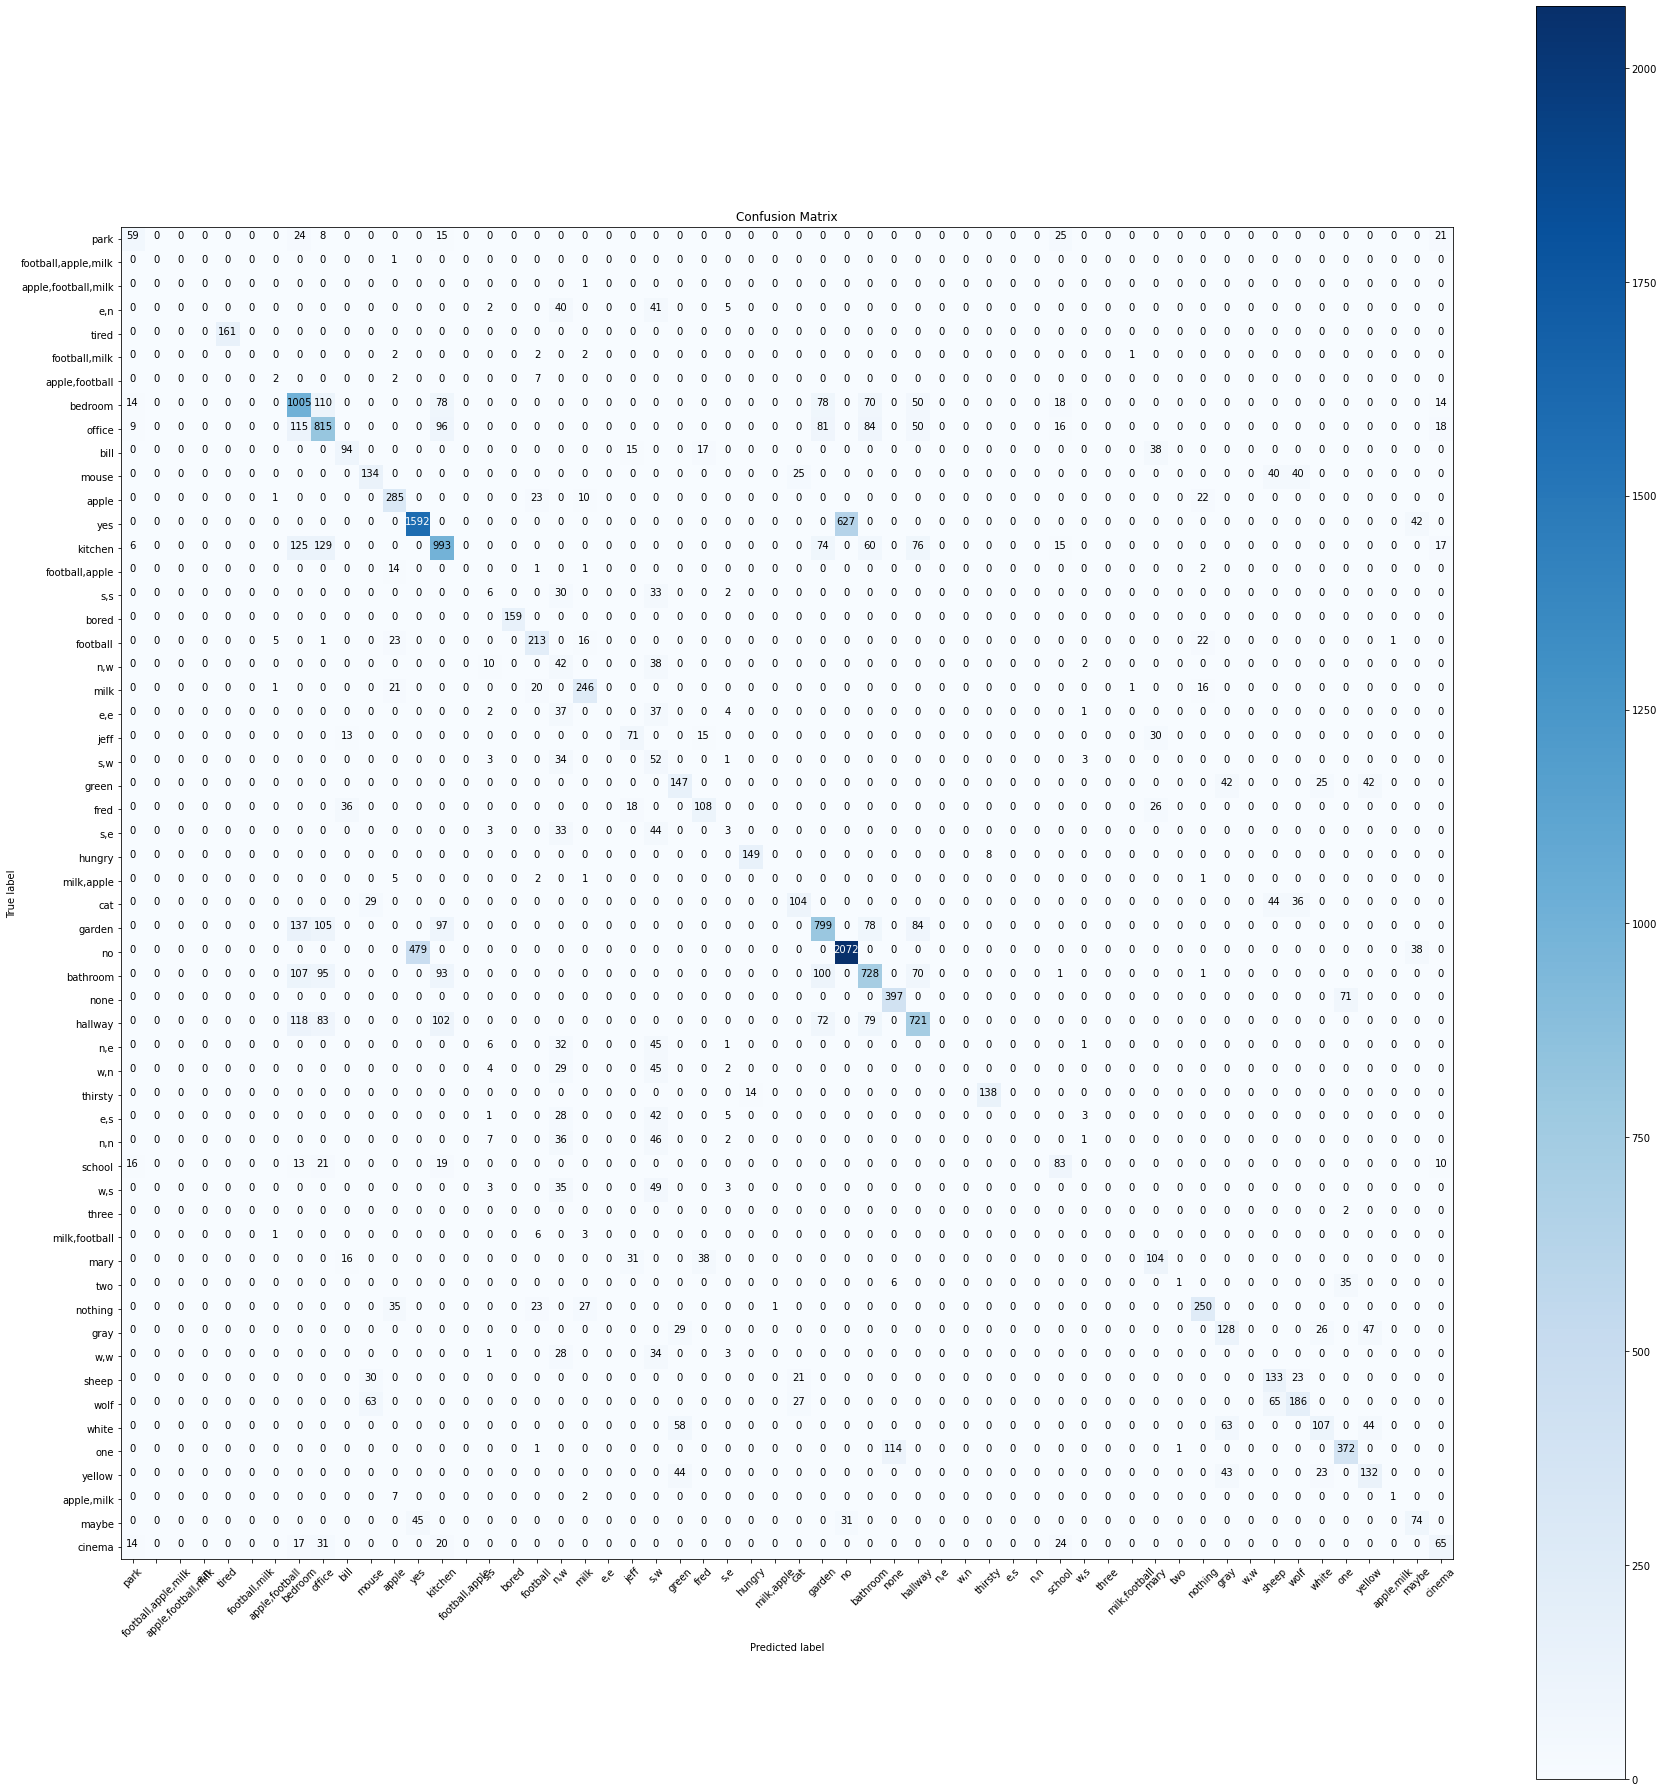

16.538029432296753


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
model.to(device)
checkpoint_name = f'checkpoints/{model_name}/best_checkpoint_{now}.pt'
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)

babi_dataset.set_mode('test')
test_loader = DataLoader(
    babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
)

y_pred_extended = []
y_true_extended = []
y_pred_task = [[] for _ in range(20)]
y_true_task = [[] for _ in range(20)]

start = time.time()
with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(test_loader, desc=f"Inference")):
        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)

        logits = torch.squeeze(model(torch.cat((contexts, questions), 1))).cpu()
        # We consider a task successfully passed if ≥ 95% accuracy is obtained.
        y_pred = m(logits)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = [babi_dataset.QA.IVOCAB[int(i)] for i in y_pred]
        y_true = [babi_dataset.QA.IVOCAB[int(i)] for i in answers.cpu()]
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_true)
        for i in range(len(y_pred)):
            y_pred_task[int(tasks[i]) - 1].append(y_pred[i])
            y_true_task[int(tasks[i]) - 1].append(y_true[i])
end = time.time()

        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
task_acc = []
passed_tasks = []
for i in range(20):
    task_acc.append(accuracy_score(y_pred_task[i], y_true_task[i]))
    passed_tasks.append(1 if task_acc[i] >= 0.95 else 0)
print(task_acc)
print('passed_tasks:', passed_tasks)
print('no. passed_tasks:', sum(passed_tasks))
labels = list(set(y_true_extended).intersection(set(y_true_extended)))
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended, labels)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, title = ('Confusion Matrix'))
plt.show()
print(end-start)

In [ ]:
# from thop import profile
# from thop import clever_format

# macs, params = profile(model, inputs=(
#                         torch.randint(1, size=(1, 910)).type(torch.LongTensor).to(device), 
#                         torch.randint(1, size=(1, 13)).type(torch.LongTensor).to(device)))  # , 
# #                         custom_ops={YourModule: count_your_model})

# macs, params = clever_format([macs, params], "%.3f")
# print(macs, params)

In [ ]:
# model.layers.append(model.layers[1])
print(len(model.layers))